In [ ]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# for getting summary info on models
from torchsummary import summary

import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [ ]:
nPerClass = 1000
imgSize = 91
x = np.linspace(-4, 4, imgSize)
X, Y = np.meshgrid(x, x)
# the two widths
widths = [1.8, 2.4]

# initialize tensors containing images and labels
images = torch.zeros(2*nPerClass, 1, imgSize, imgSize)
labels = torch.zeros(2*nPerClass)

for i in range(2*nPerClass):

    # create the gaussian with random centers
    ro = 2*np.random.randn(2) # random offset
    G = np.exp(-((X - ro[0])**2 + (Y - ro[1])**2)/(2*widths[i%2]**2))

    # add some noise
    G = G + np.random.randn(imgSize, imgSize)/5


    # add to the tensor
    images[i, :, :, :] = torch.Tensor(G).view(1, imgSize, imgSize)
    labels[i] = i%2

labels = labels[:, None]



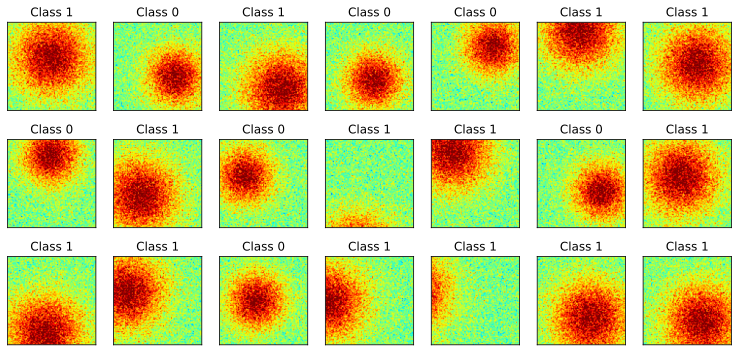

In [ ]:
fig, axs = plt.subplots(3, 7, figsize = (13, 6))

for i, ax in enumerate(axs.flatten()):
    whichpic = np.random.randint(2*nPerClass)
    G = np.squeeze(images[whichpic, :, :])
    ax.imshow(G, vmin = -1, vmax = 1, cmap = 'jet')
    ax.set_title('Class %s' %int(labels[whichpic].item()))
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

In [ ]:
train_data, test_data, train_labels, test_labels = train_test_split(images, labels, test_size = 0.1)

# convert into pytorch datasets
train_data = TensorDataset(train_data, train_labels)
test_data  = TensorDataset(test_data, test_labels)

# converting it into dataloader
train_loader = DataLoader(train_data, batch_size = 32, shuffle = True)
test_loader = DataLoader(test_data, batch_size = len(test_data))

In [ ]:
def makeTheNet():

    class gausnet(nn.Module):
        def __init__(self):
            super().__init__()

            # conv1
            self.conv1 = nn.Conv2d(1, 6, 3, padding = 1)
            # output size : (91 - 3 + 2*1)/1 + 1 = 91
            # posting pooling : 91/2 = 45

            # conv2
            self.conv2 = nn.Conv2d(6, 4, 3, padding = 1)
            # output size : (45 - 3 + 2*1)/1 + 1 = 45
            # post pooling: 45/2 = 22

            # fc1
            self.fc1 = nn.Linear(22*22*4, 50)

            # fc2
            self.fc2 = nn.Linear(50, 1)

        def forward(self, x):
            conv1act = F.relu(self.conv1(x))
            x = F.avg_pool2d(conv1act, (2, 2))

            # second conv pool set
            conv2act = F.relu(self.conv2(x))
            x = F.avg_pool2d(conv2act, (2, 2))

            # ANN part
            x = x.reshape(x.shape[0], -1)
            x = F.relu(self.fc1(x))
            x = self.fc2(x)

            return x, conv1act, conv2act

    net = gausnet()

    lossfun = nn.BCEWithLogitsLoss()

    optimizer = torch.optim.Adam(net.parameters(), lr = .001)

    return net, lossfun, optimizer

In [ ]:
net, lossfun, optimizer = makeTheNet()

# test that the model runs and can compute a loss
X, y = next(iter(train_loader))
yHat, featmap1, featmap2 = net(X)
loss = lossfun(yHat, y)

# check sizes
print('Predicted category :')
print(yHat.shape)
print('\nFeature map after conv1')
print(featmap1.shape)
print('\nFeature map after conv2')
print(featmap2.shape)


Predicted category :
torch.Size([32, 1])

Feature map after conv1
torch.Size([32, 6, 91, 91])

Feature map after conv2
torch.Size([32, 4, 45, 45])


In [ ]:
summary(net, (1, imgSize, imgSize))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 91, 91]              60
            Conv2d-2            [-1, 4, 45, 45]             220
            Linear-3                   [-1, 50]          96,850
            Linear-4                    [-1, 1]              51
Total params: 97,181
Trainable params: 97,181
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 0.44
Params size (MB): 0.37
Estimated Total Size (MB): 0.84
----------------------------------------------------------------


In [ ]:
def function2TrainTheModel():

    numepochs = 10

    # create a new model
    net, lossfun, optimizer = makeTheNet()

    # initialize losses
    trainLoss = []
    testLoss = []
    trainAcc = []
    testAcc = []


    for epochi in range(numepochs):

        net.train()
        batchAcc = []
        batchLoss = []

        for X, y in train_loader:

            yHat = net(X)[0]
            loss = lossfun(yHat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchLoss.append(loss.item())
            matches = torch.mean(((yHat > 0) == y).float()).item()
            accuracypct = 100*matches
            batchAcc.append(accuracypct)

        trainAcc.append(np.mean(batchAcc))
        trainLoss.append(np.mean(batchLoss))

        net.eval()
        X, y = next(iter(test_loader))
        with torch.inference_mode():
            yHat = net(X)[0]
            loss = lossfun(yHat, y)
            testLoss.append(loss.item())
            matches = torch.mean(((yHat > 0.5) == y).float()).item()
            accuracypct = 100*matches
            testAcc.append(accuracypct)

    return trainAcc, testAcc, trainLoss, testLoss, net





In [ ]:
trainAcc, testAcc, trainLoss, testLoss, net = function2TrainTheModel()

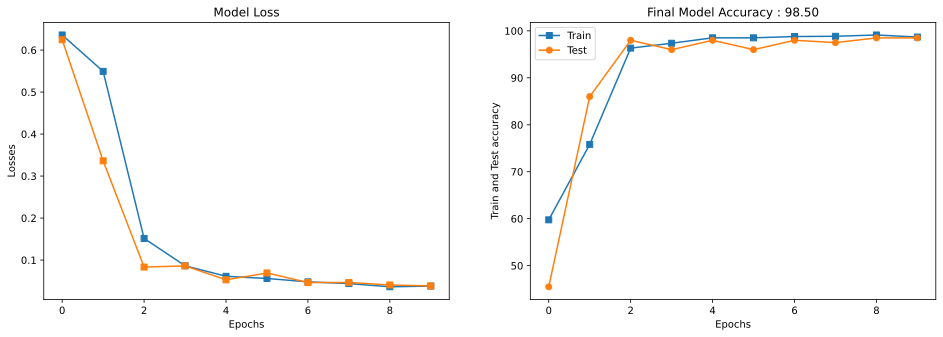

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (16, 5))

ax[0].plot(trainLoss, 's-', label = 'Train')
ax[0].plot(testLoss, 's-', label = 'Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Losses')
ax[0].set_title('Model Loss')

ax[1].plot(trainAcc, 's-', label = 'Train')
ax[1].plot(testAcc, 'o-', label = 'Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Train and Test accuracy')
ax[1].set_title(f'Final Model Accuracy : {testAcc[-1]:.2f}')
ax[1].legend()

plt.show()

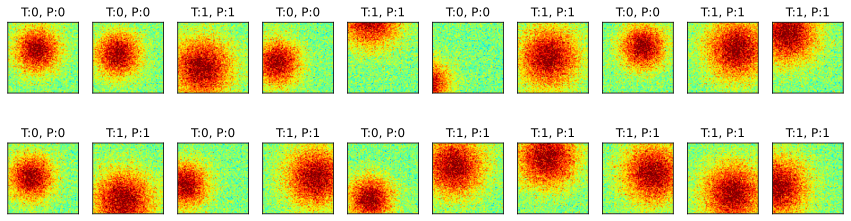

In [ ]:
X, y = next(iter(test_loader))

yHat, featmap1, featmap2 = net(X)

fig, axs = plt.subplots(2, 10, figsize = (15, 4))

for i, ax in enumerate(axs.flatten()):
    G = torch.squeeze(X[i, 0, :, :]).detach()
    ax.imshow(G, vmin = -1, vmax = 1, cmap = 'jet')
    t = (int(y[i].item()), int(yHat[i].item() > .5))
    ax.set_title('T:%s, P:%s' %t)
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

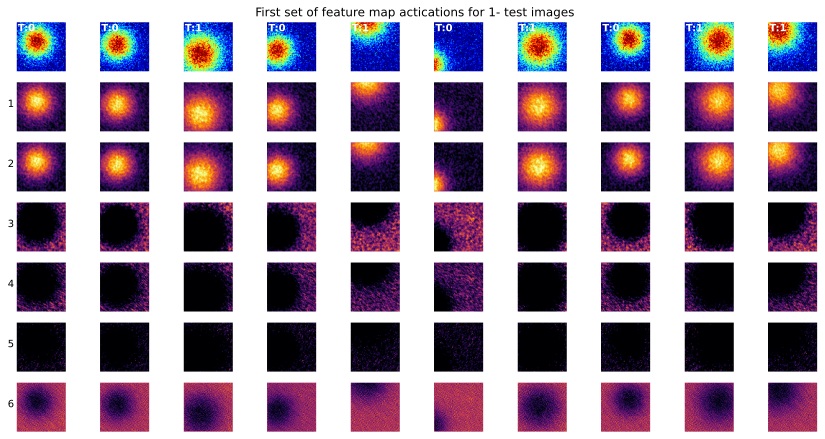

In [ ]:
fig, axs = plt.subplots(7, 10, figsize = (12, 6))

for pici in range(10):

    # show the original image
    img = X[pici, 0, :, :].detach()
    axs[0, pici].imshow(img,cmap = 'jet', vmin = 0, vmax = 1 )
    axs[0, pici].axis('off')
    axs[0, pici].text(2,2, 'T:%s' %int(y[pici].item()), ha = 'left', va = 'top', color = 'w', fontweight = 'bold')

    for feati in range(6):

        img = featmap1[pici, feati, :, :].detach()
        axs[feati + 1, pici].imshow(img, cmap = 'inferno', vmin = 0, vmax = torch.max(img)*.9)
        axs[feati + 1, pici].axis('off')
        axs[feati + 1, pici].text(-5, 45, feati+1, ha = 'right') if pici == 0 else None
plt.tight_layout()
plt.suptitle('First set of feature map actications for 10 test images ', x = .5, y = 1.01)
plt.show()

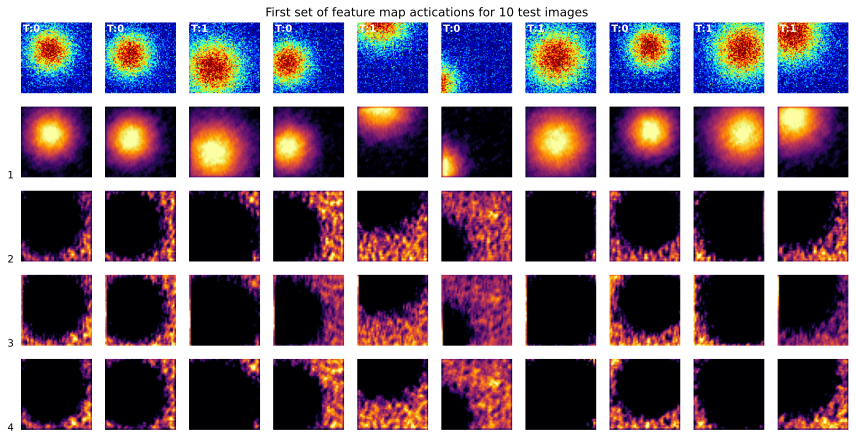

In [ ]:
fig, axs = plt.subplots(5, 10, figsize = (12, 6))

for pici in range(10):

    # show the original image
    img = X[pici, 0, :, :].detach()
    axs[0, pici].imshow(img,cmap = 'jet', vmin = 0, vmax = 1 )
    axs[0, pici].axis('off')
    axs[0, pici].text(2,2, 'T:%s' %int(y[pici].item()), ha = 'left', va = 'top', color = 'w', fontweight = 'bold')

    for feati in range(4):

        img = featmap2[pici, feati, :, :].detach()
        axs[feati + 1, pici].imshow(img, cmap = 'inferno', vmin = 0, vmax = torch.max(img)*.9)
        axs[feati + 1, pici].axis('off')
        axs[feati + 1, pici].text(-5, 45, feati+1, ha = 'right') if pici == 0 else None
plt.tight_layout()
plt.suptitle('First set of feature map actications for 10 test images ', x = .5, y = 1.01)
plt.show()

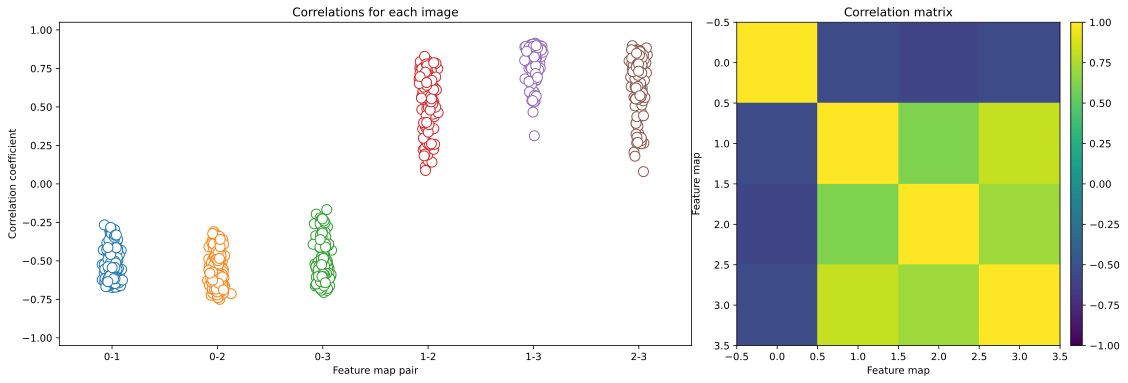

In [ ]:
### correlations across the SECOND convolution layer

# convenient variables
nStim = featmap2.shape[0]
nMaps = featmap2.shape[1]
nCors = (nMaps*(nMaps-1))//2

# initialze the matrix of all correlation values
allrs = np.zeros((nStim,nCors))
Call  = np.zeros((nMaps,nMaps))

# loop over each stimulus
for i in range(nStim):

  # extract the vectorized feature maps from this image
  featmaps = featmap2[i,:,:,:].view(nMaps,-1).detach()

  # compute the correlation matrix
  C = np.corrcoef(featmaps)
  Call += C

  # extract the unique correlations from the matrix
  idx = np.nonzero(np.triu(C,1))
  allrs[i,:] = C[idx]


# define the x-axis labels
xlab = []*nCors
for i in range(nCors):
  xlab.append('%s-%s' %(idx[0][i],idx[1][i]))




# now visualize the correlations
fig = plt.figure(figsize=(16,5))
ax0 = fig.add_axes([.1,.1,.55,.9]) # [left, bottom, width, height]
ax1 = fig.add_axes([.68,.1,.3,.9])
cax = fig.add_axes([.98,.1,.01,.9])

for i in range(nCors):
  ax0.plot(i+np.random.randn(nStim)/30,allrs[:,i],'o',markerfacecolor='w',markersize=10)

# make the plot more interpretable
ax0.set_xlim([-.5,nCors-.5])
ax0.set_ylim([-1.05,1.05])
ax0.set_xticks(range(nCors))
ax0.set_xticklabels(xlab)
ax0.set_xlabel('Feature map pair')
ax0.set_ylabel('Correlation coefficient')
ax0.set_title('Correlations for each image')


# now show the average correlation matrix
h = ax1.imshow(Call/nStim,vmin=-1,vmax=1)
ax1.set_title('Correlation matrix')
ax1.set_xlabel('Feature map')
ax1.set_ylabel('Feature map')
# add a colorbar
fig.colorbar(h,cax=cax)

plt.show()

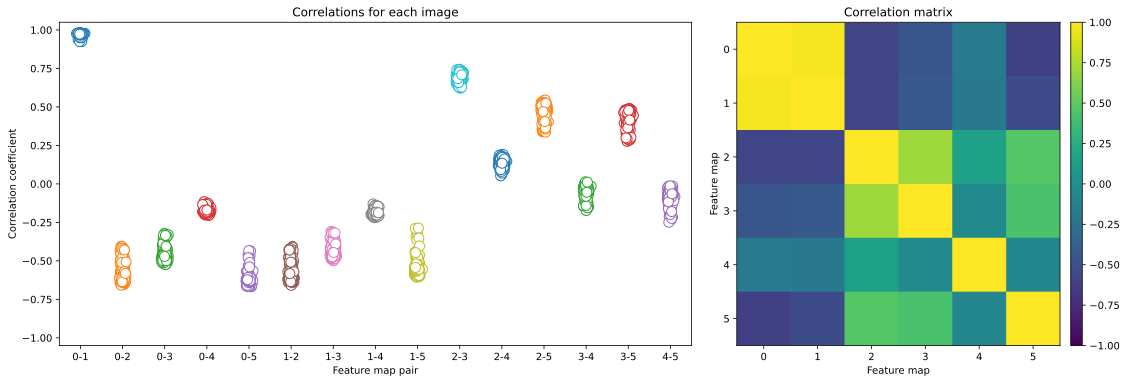

In [ ]:
# convenient variables
nStim = featmap1.shape[0]
nMaps = featmap1.shape[1]
nCors = (nMaps*(nMaps-1))//2

# initialize the matrix of all correlation values
allrs = np.zeros((nStim, nCors))
Call = np.zeros((nMaps, nMaps))

for i in range(nStim):

    # extract the vectorized feature maps from this image
    featmaps = featmap1[i, :, :, :].view(nMaps, -1).detach()

    # compute the correlation matrix
    C = np.corrcoef(featmaps)
    Call += C

    # extract the unique correlations from the matrix
    idx = np.nonzero(np.triu(C,1))
    allrs[i, :] = C[idx]

# define the x-axis labels
xlab = []*nCors
for i in range(nCors):
  xlab.append('%s-%s' %(idx[0][i],idx[1][i]))




# now visualize the correlations
fig = plt.figure(figsize=(16,5))
ax0 = fig.add_axes([.1,.1,.55,.9]) # [left, bottom, width, height]
ax1 = fig.add_axes([.68,.1,.3,.9])
cax = fig.add_axes([.98,.1,.01,.9])

for i in range(nCors):
    ax0.plot(i + np.random.randn(nStim)/30, allrs[:,i], 'o', markerfacecolor = 'w', markersize = 10)

# make the plot more interpretable
ax0.set_xlim([-.5,nCors-.5])
ax0.set_ylim([-1.05,1.05])
ax0.set_xticks(range(nCors))
ax0.set_xticklabels(xlab)
ax0.set_xlabel('Feature map pair')
ax0.set_ylabel('Correlation coefficient')
ax0.set_title('Correlations for each image')


h = ax1.imshow(Call/nStim, vmin = -1, vmax = 1)
ax1.set_title('Correlation matrix')
ax1.set_xlabel('Feature map')
ax1.set_ylabel('Feature map')
# add a colorbar
fig.colorbar(h,cax=cax)

plt.show()


In [ ]:
??np.triu